In [1]:
# Reference: https://jupyterbook.org/interactive/hiding.html
# Use {hide, remove}-{input, output, cell} tags to hiding content

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
%matplotlib inline
import ipywidgets as widgets
from ipywidgets import interact, interactive, fixed, interact_manual

sns.set()
sns.set_context('talk')
np.set_printoptions(threshold=20, precision=2, suppress=True)
pd.set_option('display.max_rows', 7)
pd.set_option('display.max_columns', 8)
pd.set_option('precision', 2)
# This option stops scientific notation for pandas
# pd.set_option('display.float_format', '{:.2f}'.format)

In [2]:
def df_interact(df, nrows=7, ncols=7):
    '''
    Outputs sliders that show rows and columns of df
    '''
    def peek(row=0, col=0):
        return df.iloc[row:row + nrows, col:col + ncols]

    row_arg = (0, len(df), nrows) if len(df) > nrows else fixed(0)
    col_arg = ((0, len(df.columns), ncols)
               if len(df.columns) > ncols else fixed(0))
    
    interact(peek, row=row_arg, col=col_arg)
    print('({} rows, {} columns) total'.format(df.shape[0], df.shape[1]))

def display_df(df, rows=pd.options.display.max_rows,
               cols=pd.options.display.max_columns):
    with pd.option_context('display.max_rows', rows,
                           'display.max_columns', cols):
        display(df)

# PCA using the Singular Value Decomposition

This section introduces the **singular value decomposition (SVD)**, a tool from linear algebra that computes the principal components of a matrix. We use SVD as a step in **principal component analysis (PCA)**.

Why are linear algebra techniques useful for data analysis? Here's one analogy. We use basic algebraic operators like addition and multiplication to summarize one-dimensional data. For example, we can compute the mean and standard deviation of the heights of Data 100 students, a one-dimensional dataset. Linear algebra provides us with matrix operators which generalize algebraic operations to multidimensional data. For instance, we can view matrix multiplication as a more general version of scalar multiplication. Linear algebra operators allow us to summarize and analyze multidimensional data.

In data analysis, we often examine data tables using both the domain of interest and linear algebra techniques. For example, we can say that every row of this data table contains the votes of a single congressperson.

In [3]:
df = pd.read_csv('vote_pivot.csv', index_col='member')

In [4]:
df

,515,516,517,518,...,552,553,554,555
member,,,,,,,,,
A000055,1,0,0,0,...,0,0,1,0
A000367,0,0,0,0,...,1,1,0,1
A000369,1,1,0,0,...,0,0,1,0
...,...,...,...,...,...,...,...,...,...
Y000062,1,1,1,1,...,1,1,1,1
Y000065,0,0,0,0,...,0,0,1,0
Z000017,1,1,0,0,...,0,0,1,0


This view allows us to answer questions like: "Were there any bills that were unanimously voted for?".

But we can also view this same table as a 441 x 41 matrix:

$$
\mathbf X = \begin{bmatrix}
1 & 0 & \cdots & 1 & 0 \\
0 & 0 & \cdots & 0 & 1 \\
  &   & \vdots &   &   \\
0 & 0 & \cdots & 1 & 0 \\
1 & 1 & \cdots & 1 & 0 \\
\end{bmatrix}
$$

Viewing data as a matrix gives us access to the rich library of tools from linear algebra, including the SVD. This allows us to answer another set of questions, such as: "What patterns of voting emerge from all the votes?"

## The Singular Value Decomposition

The singular value decomposition expresses any $ n \times d $ matrix $ \mathbf X $ as a product of three matrices $ \mathbf U $, $ \mathbf \Sigma $, and $ \mathbf V $:

$$
\begin{aligned}
\mathbf{X} &= \mathbf{U} \mathbf{\Sigma} \mathbf{V^\top}
\end{aligned}
$$

There are restrictions on $ \mathbf U $, $ \mathbf \Sigma $, and $ \mathbf V $:

1. $ \mathbf U $ has dimensions $ n \times n $, $ \mathbf \Sigma $ has dimensions $ n \times d $, and $ \mathbf V $ has dimensions $ d \times d $.
1. $ \mathbf U $ and $ \mathbf V $ are orthogonal matrices. That is, $ \mathbf U^\top \mathbf U = \mathbf I $ and $ \mathbf V^\top \mathbf V = \mathbf I $. This also implies that all columns of $ \mathbf{U} $ and $ \mathbf{V} $ have magnitude 1 and are mutually orthogonal.
1. $ \mathbf{\Sigma} $ is a diagonal matrix. That is, all elements in $ \mathbf{\Sigma} $ are 0 unless they lie on the diagonal. In addition, the diagonal elements in $ \mathbf{\Sigma} $ are arranged from biggest to smallest.

As a simple example, if we have:

$$
\begin{aligned}
\mathbf{X} = \begin{bmatrix}
1 & 0 \\
0 & 4 \\
0 & 0 \\
\end{bmatrix}
\end{aligned}
$$

The SVD of $ \mathbf{X} $ is:

$$
\begin{aligned}
\mathbf{X}
&= \mathbf{U} \mathbf{\Sigma} \mathbf{V^\top} \\
&= \begin{bmatrix}
0 & 1 & 0 \\
1 & 0 & 0\\
0 & 0 & 1 \\
\end{bmatrix}
\begin{bmatrix}
4 & 0 \\
0 & 1 \\
0 & 0 \\
\end{bmatrix}
\begin{bmatrix}
0 & 1 \\
1 & 0 \\
\end{bmatrix}
\end{aligned}
$$

We can check that this decomposition reproduces $ \mathbf{X} $:

In [5]:
U = np.array([
    [0, 1, 0],
    [1, 0, 0],
    [0, 0, 1],
])
S = np.array([
    [4, 0],
    [0, 1],
    [0, 0],
])
V = np.array([
    [0, 1],
    [1, 0],
])

U @ S @ V.T

array([[1, 0],
       [0, 4],
       [0, 0]])

We can also check that the matrices $ \mathbf U $, $ \mathbf \Sigma $, and $ \mathbf V $ fulfill the requirements of the SVD.

First: $ \mathbf{X} $ has dimensions $ 3 \times 2 $. $ \mathbf U $ has dimensions $ 3 \times 3 $, $ \mathbf \Sigma $ has dimensions $ 3 \times 2 $, and $ \mathbf V $ has dimensions $ 2 \times 2 $.

Second: $ \mathbf U $ and $ \mathbf V $ are orthogonal matrices:

In [6]:
U @ U.T

array([[1, 0, 0],
       [0, 1, 0],
       [0, 0, 1]])

In [7]:
V @ V.T

array([[1, 0],
       [0, 1]])

Third: $ \mathbf \Sigma $ is diagonal, and its diagonal elements are arranged from greatest to least.

In [8]:
S

array([[4, 0],
       [0, 1],
       [0, 0]])

### Computing the SVD in Python

To compute the SVD in Python, we use the `np.linalg.svd` function:

In [9]:
svd = np.linalg.svd

X = np.array([
    [1, 0],
    [0, 4],
    [0, 0]
])
svd(X)

(array([[0., 1., 0.],
        [1., 0., 0.],
        [0., 0., 1.]]),
 array([4., 1.]),
 array([[0., 1.],
        [1., 0.]]))

`np.linalg.svd` returns a tuple of three arrays corresponding to $ \mathbf{U} $, $ \mathbf{\Sigma} $, and $ \mathbf{V^\top} $. Notice that the $ \mathbf{\Sigma} $ value is one-dimensional numpy array rather than a diagonal matrix, which can cause problems recreating $\mathbf{X}$ using the return values of `np.linalg.svd`. For convenience, we often use `full_matrices=False` in our call to `np.linalg.svd`, which reduces the dimensions of $ \mathbf{U} $ or $ \mathbf{V^\top} $ to match the dimensions of $ \mathbf{\Sigma} $:

In [10]:
svd(X, full_matrices=False)

(array([[0., 1.],
        [1., 0.],
        [0., 0.]]),
 array([4., 1.]),
 array([[0., 1.],
        [1., 0.]]))

This allows us to use `np.diag` to create the diagonal matrix $ \mathbf{\Sigma} $ and reproduce the original $ \mathbf{X} $:

In [11]:
U, S, Vt = svd(X, full_matrices=False)
U @ np.diag(S) @ Vt

array([[1., 0.],
       [0., 4.],
       [0., 0.]])

This takes advantage of the fact that an all-zero row in a matrix multiplication can be removed, in this case:

$$
\begin{aligned}
\mathbf{X}
&= \mathbf{U} \mathbf{\Sigma} \mathbf{V^\top} \\
&= \begin{bmatrix}
0 & 1 & 0 \\
1 & 0 & 0\\
0 & 0 & 1 \\
\end{bmatrix}
\begin{bmatrix}
4 & 0 \\
0 & 1 \\
0 & 0 \\
\end{bmatrix}
\begin{bmatrix}
0 & 1 \\
1 & 0 \\
\end{bmatrix} \\
&=
\begin{bmatrix}
0 & 1 \\
1 & 0 \\
0 & 0 \\
\end{bmatrix}
\begin{bmatrix}
4 & 0 \\
0 & 1 \\
\end{bmatrix}
\begin{bmatrix}
0 & 1 \\
1 & 0 \\
\end{bmatrix}
\end{aligned}
$$

Note that we select this example for simplicity. As we will soon see, for real datasets the elements of $ \mathbf{U} $, $ \mathbf{\Sigma} $, and $ \mathbf{V^\top} $ are rarely integers.

## Principal Directions

SVD takes a data matrix $ \mathbf{X} $ and produces the matrix factorization $\mathbf{X} = \mathbf{U} \mathbf{\Sigma} \mathbf{V^\top}$. This factorization has useful properties that we use to perform dimensionality reduction.

First, we examine $ \mathbf{V^\top} $. The rows of $ \mathbf{V^\top} $ (or equivalently the columns of the untransposed $ \mathbf{V} $) contain the **principal directions** for the matrix $ \mathbf{X} $. Consider the following dataset of country-level child mortality and fertility:

In [19]:
child_data = pd.read_csv('child_data.csv', index_col='country')
child_data

,mortality,fertility
country,,
Afghanistan,6.82,4.48
Albania,1.33,1.71
Algeria,2.39,2.71
...,...,...
Yemen,5.30,3.89
Zambia,6.16,4.93
Zimbabwe,5.68,3.68


To examine the principal directions of this data matrix, we first **center** the data by subtracting the mean of each column.

In [24]:
cntr_child = child_data - child_data.mean(axis=0)
cntr_child

,mortality,fertility
country,,
Afghanistan,3.79,1.70
Albania,-1.70,-1.07
Algeria,-0.64,-0.07
...,...,...
Yemen,2.27,1.11
Zambia,3.13,2.15
Zimbabwe,2.65,0.90


Then, we compute the SVD and display the values in $ \mathbf{V^\top} $.

In [28]:
U, S, Vt = svd(cntr_child, full_matrices=False)
Vt

array([[-0.93, -0.37],
       [-0.37,  0.93]])

We plot the rows of $ \mathbf{V^\top} $ as vectors on top of a scatter plot of the original data (we scaled the vectors for presentation). The first row of $ \mathbf{V^\top} $ is drawn in red, and the second in purple.

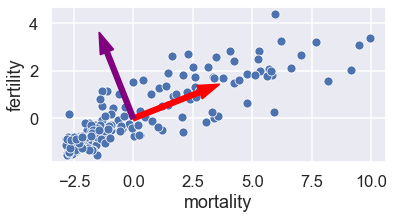

In [43]:
sns.scatterplot(data=cntr_child, x='mortality', y='fertility')
plt.arrow(0, 0, -3 * Vt[0, 0], -3 * Vt[0, 1], width=0.2, color='red')
plt.arrow(0, 0, 3 * Vt[1, 0], 3 * Vt[1, 1], width=0.2, color='purple')
plt.gca().set_aspect(1)

Observe that the principal directions of $ \mathbf{X} $, or the rows of $ \mathbf{V^\top} $, seem to align themselves with the direction that the data vary. This is no coincidence: the principal directions of $ \mathbf{X} $ are precisely the orthogonal directions where $ \mathbf{X} $ has the greatest variance.

As another example, we plot the principal directions for a dataset of human abdomen and density measurements. Again, the first principal direction is drawn in red and the second in purple.

In [78]:
#http://jse.amstat.org/datasets/fat.txt
fat = (
    pd.read_fwf("fat.dat.txt", colspecs = [(17, 21), (23, 29), (35, 37),
                                            (39, 45), (48, 53), (73, 77),
                                            (80, 85), (88, 93)], header=None,
                names = ["% fat", "density", "age", "weight", "height", "neck", "chest", "abdomen"])
    .query('height >= 40')
)
df = fat[['density', 'abdomen']]
df = df.assign(density=df['density'] * 1000)

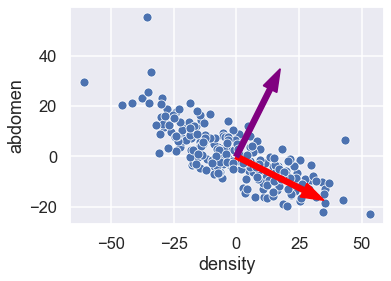

In [84]:
df = df - df.mean(axis=0)
U, S, Vt = svd(df, full_matrices=False)
sns.scatterplot(data=df, x='density', y='abdomen')
dirs = -30 * Vt
plt.arrow(0, 0, dirs[0, 0], dirs[0, 1], width=2, color='red')
plt.arrow(0, 0, dirs[1, 0], dirs[1, 1], width=2, color='purple')
plt.gca().set_aspect(1)

## Principal Component Analysis

We can use principal directions to sketch a procedure for dimensionality reduction. First, we find the principal directions of $ \mathbf{X} $ by centering $ \mathbf{X} $, then using the SVD. If $ \mathbf{X} $ has 100 dimensions, this will produce 100 principal directions. Next, we decide how many dimensions we want to reduce to; a common choice is 2. To reduce to 2 dimensions, we keep the first two principal directions and throw out the other 98. Finally, we project the data onto the first two directions. This is **principal component analysis (PCA)**, a method for dimensionality reduction.

To illustrate PCA, we will reduce the mortality/fertility dataset from two dimensions to one dimension. The data is loaded in the `child_data` DataFrame:

In [86]:
child_data

,mortality,fertility
country,,
Afghanistan,6.82,4.48
Albania,1.33,1.71
Algeria,2.39,2.71
...,...,...
Yemen,5.30,3.89
Zambia,6.16,4.93
Zimbabwe,5.68,3.68


As before, we center `child_data` by subtracting each column by its column mean.

In [87]:
cntr_child = child_data - child_data.mean(axis=0)
cntr_child

,mortality,fertility
country,,
Afghanistan,3.79,1.70
Albania,-1.70,-1.07
Algeria,-0.64,-0.07
...,...,...
Yemen,2.27,1.11
Zambia,3.13,2.15
Zimbabwe,2.65,0.90


Next, we find the SVD of this data:

In [88]:
U, S, Vt = svd(cntr_child, full_matrices=False)
U, S, Vt

(array([[-0.1 ,  0.02],
        [ 0.05, -0.04],
        [ 0.01,  0.02],
        ...,
        [-0.06,  0.02],
        [-0.09,  0.1 ],
        [-0.06, -0.02]]),
 array([43.48,  8.2 ]),
 array([[-0.93, -0.37],
        [-0.37,  0.93]]))

Recall that SVD computes $\mathbf{X} = \mathbf{U} \mathbf{\Sigma} \mathbf{V^\top}$, and the matrix $ \mathbf{V^\top} $ contains the two principal directions of $ \mathbf{X} $. To remove a direction, we simply drop the last row from $ \mathbf{V^\top} $:

In [110]:
Vt[:1]

array([[-0.93, -0.37]])

Finally, we project the original data points $ \mathbf{X} $ onto the single principal direction. Since the SVD enforces that principal directions in $ \mathbf{V^\top} $ have magnitude one, this a simply a matrix multiplication $ \mathbf{X} \mathbf{V} $, after removing a direction from $ \mathbf{V} $:

In [134]:
X @ Vt[:1].T

array([[-4.15],
       [ 1.98],
       [ 0.62],
       ...,
       [-2.52],
       [-3.7 ],
       [-2.79]])

We have successfully performed PCA to reduce $ \mathbf{X} $ from 2 dimensions to 1. Dimensionality reduction attempts to summarize the data with fewer dimensions while preserving patterns in the data. One way to verify this is to check that points that appear together in the two-dimensional data (scatter plot) also appear together one-dimensional data (rug plot).

![pca_svd_one_vs_two.png](pca_svd_one_vs_two.png)

In [ ]:
# For figures
# plt.figure(figsize=(4, 1))
# one_d = (X @ Vt[:1].T)[:, 0]
# sns.rugplot(one_d, height=0.6)
# sns.scatterplot(data=cntr_child, x='mortality', y='fertility')

In practice, we use a simpler method to compute the reduced dimension $ \mathbf{X} $ which arises from the following equivalence:

$$
\begin{aligned}
\mathbf{X} &= \mathbf{U} \mathbf{\Sigma} \mathbf{V^\top} \\
\mathbf{X} \mathbf{V} &= \mathbf{U} \mathbf{\Sigma} \mathbf{V^\top} \mathbf{V} & \text{Right-multiply by $ \mathbf{V} $} \\
\mathbf{X} \mathbf{V} &= \mathbf{U} \mathbf{\Sigma} & \text{Since $ \mathbf{V^\top} \mathbf{V} = \mathbf{I} $} \\
\end{aligned}
$$

This means that instead of removing rows from $ \mathbf{V^\top} $ and then computing $ \mathbf{X} \mathbf{V} $ , we can compute $ \mathbf{U} \mathbf{\Sigma} $ and then remove columns until we achieve our desired dimensionality. For this reason, we call the columns of $ \mathbf{U} \mathbf{\Sigma} $ the **principal components** of $ \mathbf{X} $.

To reduce $ \mathbf{X} $ from 2 to 1 dimension, we can compute the principal components:

In [135]:
pcs = U @ np.diag(S)
pcs

array([[-4.15,  0.19],
       [ 1.98, -0.36],
       [ 0.62,  0.18],
       ...,
       [-2.52,  0.2 ],
       [-3.7 ,  0.85],
       [-2.79, -0.13]])

Then drop the rightmost column:

In [136]:
pcs[:, :1]

array([[-4.15],
       [ 1.98],
       [ 0.62],
       ...,
       [-2.52],
       [-3.7 ],
       [-2.79]])

Notice that this produces the same result as right multiplying $ \mathbf{X} $ with a truncated $ \mathbf{V} $:

In [137]:
X @ Vt[:1].T

array([[-4.15],
       [ 1.98],
       [ 0.62],
       ...,
       [-2.52],
       [-3.7 ],
       [-2.79]])

With this, we can describe the final procedure for PCA. To reduce an $ n \times d $ matrix $ \mathbf{X} $ to $ k $ dimensions (where $ k < d $), we perform the following steps:

1. Center $ \mathbf{X} $ .
2. Use the SVD to find $ \mathbf{X} = \mathbf{U} \mathbf{\Sigma} \mathbf{V^\top} $ .
3. Compute the principal components $ \mathbf{U} \mathbf{\Sigma} $ . 
4. Keep the first $ k $ columns of $ \mathbf{U} \mathbf{\Sigma} $ .

## Rank-k Approximation

We can also use PCA to construct a **rank-k approximation** of $ \mathbf{X} $, which produces a rank $ k $ matrix with the same dimensions as $ \mathbf{X} $. The rank-k appromixation projects the points in $ \mathbf{X} $ onto the top $ k $ principal directions. The procedure is similar to that of PCA:

1. Center $ \mathbf{X} $ .
2. Use the SVD to find $ \mathbf{X} = \mathbf{U} \mathbf{\Sigma} \mathbf{V^\top} $ .
3. Keep the first $ k $ columns of $ \mathbf{U} \mathbf{\Sigma} $ , and the first $ k $ rows of $ \mathbf{V^\top} $.
4. Compute $ \mathbf{X} \approx \mathbf{U} \mathbf{\Sigma} \mathbf{V^\top} $ with the reduced $ \mathbf{U} \mathbf{\Sigma} $ and $ \mathbf{V^\top} $.

The function below provides an implementation:

In [142]:
def compute_rank_k_approximation(data, k):
    centered = data - data.mean(axis=0)
    U, S, Vt = np.linalg.svd(centered, full_matrices = False)
    approx = (U @ np.diag(S))[:, :k] @ Vt[:k]
    return pd.DataFrame(approx, columns = data.columns)

As an example, we will compute the rank-1 approximation of the mortality/fertility data:

In [144]:
rank_1 = compute_rank_k_approximation(child_data, 1)
rank_1

,mortality,fertility
0,3.86,1.53
1,-1.84,-0.73
2,-0.58,-0.23
...,...,...
180,2.34,0.93
181,3.44,1.36
182,2.60,1.03


We plot the original data in blue and the rank-1 approximation in orange:

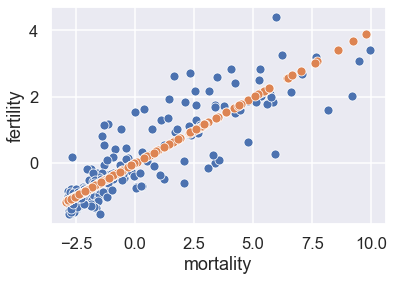

In [146]:
sns.scatterplot(data=cntr_child, x='mortality', y='fertility')
sns.scatterplot(data=rank_1, x='mortality', y='fertility');

Observe that the rank-1 approximation projects each point in $ \mathbf{X} $ along the direction of the first principal direction.

## Summary

This section introduces the singular value decomposition and uses the SVD to perform principal components analysis for dimensionality reduction.